<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#MFCC(Mel-Frequency-Cepstral-Coefficient)" data-toc-modified-id="MFCC(Mel-Frequency-Cepstral-Coefficient)-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>MFCC(Mel Frequency Cepstral Coefficient)</a></span></li><li><span><a href="#WaveNet" data-toc-modified-id="WaveNet-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>WaveNet</a></span></li><li><span><a href="#CTC(Connectionist-temporal-classification)" data-toc-modified-id="CTC(Connectionist-temporal-classification)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>CTC(Connectionist temporal classification)</a></span></li></ul></li><li><span><a href="#Code" data-toc-modified-id="Code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="#data" data-toc-modified-id="data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#MFCC" data-toc-modified-id="MFCC-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>MFCC</a></span></li><li><span><a href="#Vocab" data-toc-modified-id="Vocab-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Vocab</a></span></li><li><span><a href="#input-data" data-toc-modified-id="input-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>input data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#input" data-toc-modified-id="input-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>input</a></span></li><li><span><a href="#layers" data-toc-modified-id="layers-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>layers</a></span></li><li><span><a href="#model" data-toc-modified-id="model-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>model</a></span></li><li><span><a href="#loss" data-toc-modified-id="loss-1.5.4"><span class="toc-item-num">1.5.4&nbsp;&nbsp;</span>loss</a></span></li><li><span><a href="#train" data-toc-modified-id="train-1.5.5"><span class="toc-item-num">1.5.5&nbsp;&nbsp;</span>train</a></span></li></ul></li><li><span><a href="#Test" data-toc-modified-id="Test-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Test</a></span></li></ul></li></ul></div>

Automatic Speech Recognition将语音转换成文本，使用WaveNet实现声学特征到文本的转换关系学习。

Pipline选择如下：
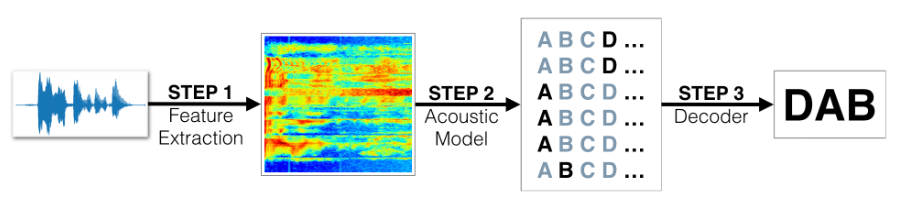

#### MFCC(Mel Frequency Cepstral Coefficient)

梅尔频率倒谱系数是模型输入的声学特征，使用 [python_speech_features](https://github.com/jameslyons/python_speech_features) 包提取特征。

> 依赖包：  
> pip install python_speech_features librosa  
> conda install -c conda-forge ffmpeg

声音中不同的来源的部分会被不同shape的声道所捕捉。而如果我们可以准确地确定声道shape，就可以准确捕捉到不同声源的 phoneme 。

声道的形状表现为短时功率谱的 envelope，而MFCC的工作是准确地表示该 envelope。

计算步骤：  [reference](http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)
1. Frame the signal into short frames.
2. For each frame calculate the periodogram estimate of the power spectrum.
3. Apply the mel filterbank to the power spectra, sum the energy in each filter.
4. Take the logarithm of all filterbank energies.
5. Take the DCT of the log filterbank energies.
6. Keep DCT coefficients 2-13, discard the rest.

DCT：离散余弦变换，类似DFT(离散傅里叶变换).  
计算得到的多个short frames的2-13维度的特征表示。可以理解为word的word embedding。


人类在分辨低频时音调的细微变化方面要比高频好得多

Mel scale计算方法：


#### WaveNet

https://arxiv.org/abs/1609.03499

WaveNet输入MFCC特征，预测对应文本。使用 stack ofdilatedcausal convolutional layers 提取输入信息在不同区域内的特征。

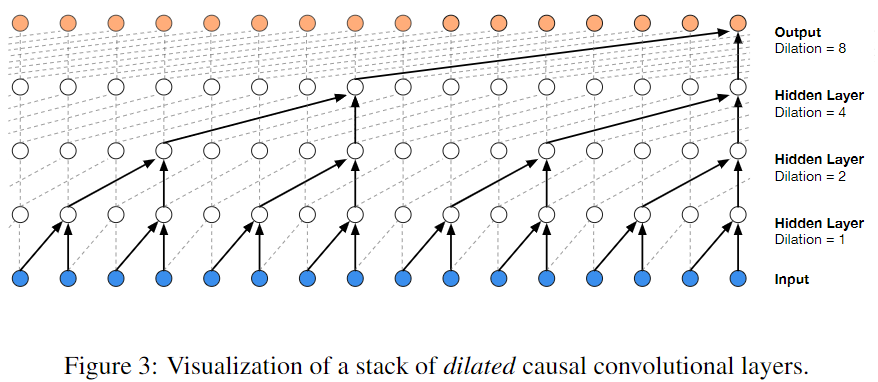

每一层 Hidden layer 通过 residual block 输出特征表示
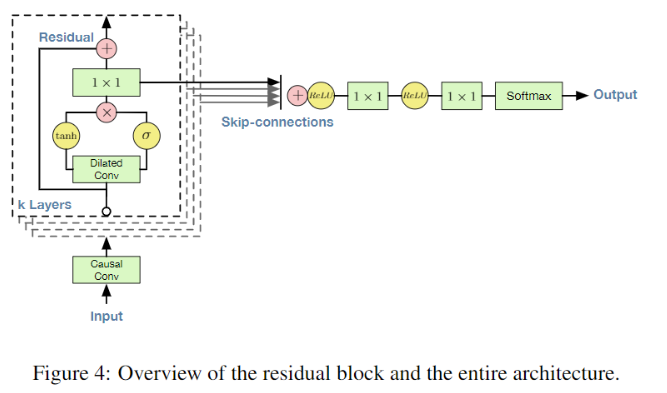

模型的难点在于，音频特征输入中，不同文字的发音长短、轻重等不同，而对应文本序列是比较整齐的。所以和普通seq2seq有所不同。

#### CTC(Connectionist temporal classification)

CTC（Connectionist temporal classification）对时序类数据分类的算法的损失函数。用来衡量输入的序列数据经过神经网络之后，和真实的输出相差有多少。

CTC处理声学模型训练，不需要数据对齐和一一标注，是一种完全端到端的声学模型训练，不关心预测输出序列中每个结果在时间点上是否和输入的序列正好对齐。

将振幅小的非spike（尖峰）区域标记为‘blank’，并且不关心spike的持续时间。

简单来讲，就是计算MFCC特征和WaveNet提取后的特征表示之间的Loss。

### Code

reference：https://github.com/buriburisuri/speech-to-text-wavenet

In [2]:
from keras.models import Model
from keras.layers import Input, Activation, Conv1D, Lambda, Add, Multiply, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import random
import pickle
import glob
from tqdm import tqdm_notebook
import os

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio

#### data
http://www.openslr.org/18/

In [3]:
# 文本文档
text_paths = glob.glob('data/*.trn')
total = len(text_paths)
print(total)

with open(text_paths[0], 'r', encoding='utf8') as fr:
    lines = fr.readlines()
    print(lines)

13388
['绿 是 阳春 烟 景 大块 文章 的 底色 四月 的 林 峦 更是 绿 得 鲜活 秀媚 诗意 盎然\n', 'lv4 shi4 yang2 chun1 yan1 jing3 da4 kuai4 wen2 zhang1 de5 di3 se4 si4 yue4 de5 lin2 luan2 geng4 shi4 lv4 de5 xian1 huo2 xiu4 mei4 shi1 yi4 ang4 ran2\n', 'l v4 sh ix4 ii iang2 ch un1 ii ian1 j ing3 d a4 k uai4 uu un2 zh ang1 d e5 d i3 s e4 s iy4 vv ve4 d e5 l in2 l uan2 g eng4 sh ix4 l v4 d e5 x ian1 h uo2 x iu4 m ei4 sh ix1 ii i4 aa ang4 r an2\n']


In [4]:
# 提取文本标注和语音文件路径，保留中文并去掉空格
texts = []
paths = []
for path in text_paths:
    
    with open(path, 'r', encoding='utf8') as fr:
        lines = fr.readlines()
        line = lines[0].strip('\n').replace(' ', '')
        texts.append(line)
        paths.append(path.rstrip('.trn'))

print(paths[0], texts[0])

data\A11_0.wav 绿是阳春烟景大块文章的底色四月的林峦更是绿得鲜活秀媚诗意盎然


#### MFCC

In [7]:
def load_and_trim(path):
    # sr: 采样率
    audio, sr = librosa.load(path)
    # 计算总的energy
    energy = librosa.feature.rms(audio)
    # 剔除energy 较小的边缘部分
    frames = np.nonzero(energy >= np.max(energy) / 5)
    # 从原audio中提取 特征明显的有语音 部分
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    
    return audio, sr

In [24]:
# 提取文件MFCC
mfcc_dim = 13  # 特征维度
features = []
for i in tqdm_notebook(range(total)):
    path = paths[i]
    audio, sr = load_and_trim(path)
    features.append(mfcc(audio, sr, numcep=mfcc_dim, nfft=551))
    
print(len(features), features[0].shape)


# MFCC归一化
# 采样
samples = random.sample(features, 100)
samples = np.vstack(samples)

# 样本均值，方差
mfcc_mean = np.mean(samples, axis=0)
mfcc_std = np.std(samples, axis=0)

# 归一化
features = [(feature - mfcc_mean) / (mfcc_std + 1e-14) for feature in features]

13388 (611, 13)


Audio Text: 国防大学政委王茂润中将与延安八一敬老院八十五岁的老红军柴福耀亲切交谈


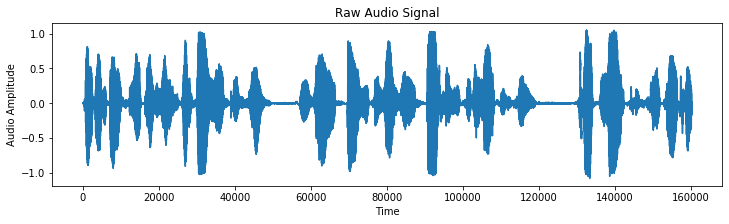

Shape of MFCC: (724, 13)


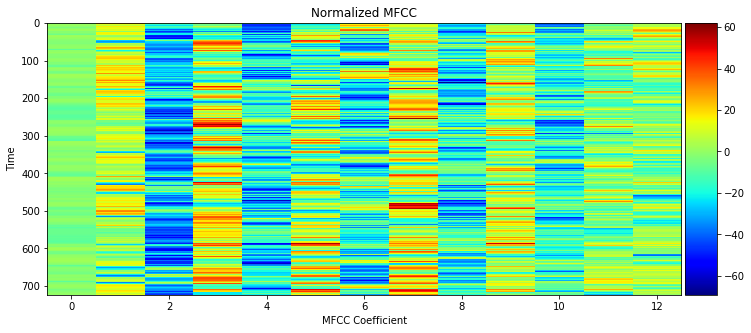

In [11]:
def visualize(index):
    """可视化mfcc"""
    path = paths[index]
    text = texts[index]
    print('Audio Text:', text)

    audio, sr = load_and_trim(path)
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio)), audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Audio Amplitude')
    plt.show()

    feature = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    print('Shape of MFCC:', feature.shape)

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(im,
                        cax=make_axes_locatable(ax).append_axes('right',
                                                                                               size='5%',
                                                                                               pad=0.05))
    ax.set_xticks(np.arange(0, 13, 2), minor=False)
    plt.show()

    return path


Audio(visualize(77))

#### Vocab

In [12]:
chars = {}
for text in texts:
    for c in text:
        chars[c] = chars.get(c, 0) + 1

chars = sorted(chars.items(), key=lambda x: x[1], reverse=True)
chars = [char[0] for char in chars]
print(len(chars), chars[:10])

char2id = {c: i for i, c in enumerate(chars)}
id2char = {i: c for i, c in enumerate(chars)}

2883 ['的', '一', '有', '人', '了', '不', '为', '在', '是', '十']


In [25]:
with open('dictionary.pkl', 'wb') as fw:
    # 保存训练集的mfcc_mean, mfcc_std
    # 完成测试集的归一化
    pickle.dump([char2id, id2char, mfcc_mean, mfcc_std], fw)

#### input data

In [26]:
# shuffle data
data_index = np.arange(total)
np.random.shuffle(data_index)
train_size = int(0.9 * total)
test_size = total - train_size
train_index = data_index[:train_size]
test_index = data_index[train_size:]

# train and test
X_train = [features[i] for i in train_index]
Y_train = [texts[i] for i in train_index]
X_test = [features[i] for i in test_index]
Y_test = [texts[i] for i in test_index]

In [27]:
def batch_generator(x, y, batch_size=batch_size, mfcc_dim=mfcc_dim, char2id=char2id):  
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            data_index = np.arange(len(x))
            np.random.shuffle(data_index)
            x = [x[i] for i in data_index]
            y = [y[i] for i in data_index]
            offset = batch_size
            
        X_data = x[offset - batch_size: offset]
        Y_data = y[offset - batch_size: offset]
        
        X_maxlen = max([X_data[i].shape[0] for i in range(batch_size)])
        Y_maxlen = max([len(Y_data[i]) for i in range(batch_size)])
        
        X_batch = np.zeros([batch_size, X_maxlen, mfcc_dim])
        Y_batch = np.ones([batch_size, Y_maxlen]) * len(char2id)
        X_length = np.zeros([batch_size, 1], dtype='int32')
        Y_length = np.zeros([batch_size, 1], dtype='int32')
        
        for i in range(batch_size):
            # X_length：特征片段数量，for CTC
            X_length[i, 0] = X_data[i].shape[0]
            X_batch[i, :X_length[i, 0], :] = X_data[i]
            
            # Y_length：预测文本长度
            Y_length[i, 0] = len(Y_data[i])
            Y_batch[i, :Y_length[i, 0]] = [char2id[c] for c in Y_data[i]]
        
        inputs = {'X': X_batch, 'Y': Y_batch, 'X_length': X_length, 'Y_length': Y_length}
        outputs = {'ctc': np.zeros([batch_size])}
        
        yield (inputs, outputs)

#### Model


In [29]:
epochs = 50
num_blocks = 3
filters = 128
batch_size = 16
mfcc_dim = 13

##### input

In [30]:
X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')

X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')

##### layers

 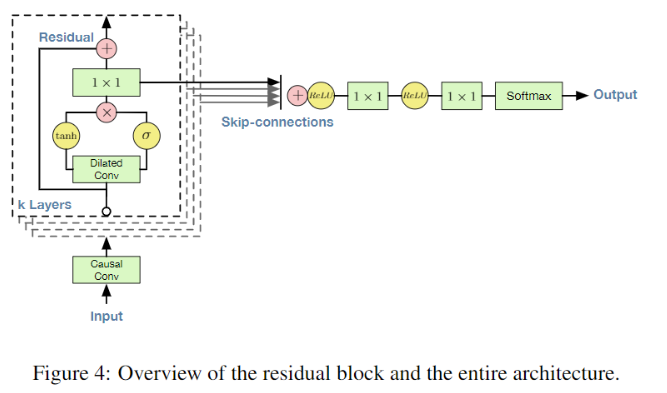

In [16]:
def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters,
                  kernel_size=kernel_size,
                  strides=1,
                  padding='causal',
                  activation=None,
                  dilation_rate=dilation_rate)(inputs)


def batchnorm(inputs):
    return BatchNormalization()(inputs)


def activation(inputs, activation):
    return Activation(activation)(inputs)


def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(
        batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(
        batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)),
        'sigmoid')
    h0 = Multiply()([hf, hg])
    
    # to next layer
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    # to output feature extraction
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')

    return Add()([ha, inputs]), hs

##### model

In [19]:
h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')

# 不同大小空洞卷积的block
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)
        
# 不同层次的特征抽取结合
h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')

# 预测为vocab size大小的概率分布
Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')

# 预测时使用的Model。因为预测不用计算CTC loss，只需要子模型
sub_model = Model(inputs=X, outputs=Y_pred)

Instructions for updating:
Colocations handled automatically by placer.


##### loss

In [20]:
def calc_ctc_loss(args):
    ytrue, ypred, yplen, ylen = args
    # 使用keras 的CTC loss API
    return K.ctc_batch_cost(ytrue, ypred, yplen, ylen)


ctc_loss = Lambda(calc_ctc_loss, output_shape=(1, ),
                               name='ctc')([Y, Y_pred, X_length, Y_length])
optimizer = SGD(lr=0.02, momentum=0.9, nesterov=True, clipnorm=5)

model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred},
                         optimizer=optimizer)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


##### train

In [ ]:
# 但每隔一轮loss没有下降，减小lr为0.2倍
lr_decay = ReduceLROnPlateau(monitor='loss',
                                                    factor=0.2,
                                                    patience=1,
                                                    min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_test, Y_test), 
    validation_steps=len(X_test) // batch_size, 
    callbacks=[lr_decay])

# save
sub_model.save('asr.h5')

In [ ]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.plot(np.linspace(1, epochs, epochs), train_loss, label='train')
plt.plot(np.linspace(1, epochs, epochs), valid_loss, label='valid')

plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

#### Test

In [1]:
from keras.models import load_model
from keras import backend as K
import numpy as np
import librosa
from python_speech_features import mfcc
import pickle
import glob

Using TensorFlow backend.


In [2]:
# wav音频文件，可以更改为其他文件
wavs = glob.glob('data/*.wav')

In [3]:
# load model
with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

mfcc_dim = 13
model = load_model('asr.h5')

Instructions for updating:
Colocations handled automatically by placer.


D:\ProgramData\Anaconda3\envs\nlp\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
index = np.random.randint(len(wavs))
print(wavs[index])

# 音频提取mfcc
audio, sr = librosa.load(wavs[index])
energy = librosa.feature.rms(audio)
frames = np.nonzero(energy >= np.max(energy) / 5)
indices = librosa.core.frames_to_samples(frames)[1]
audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]

X_data = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
X_data = (X_data - mfcc_mean) / (mfcc_std + 1e-14)
print(X_data.shape)

# 这是已有的数据，来自训练集，识别自己的音频文件请忽略
with open(wavs[index] + '.trn', 'r', encoding='utf8') as fr:
    label = fr.readlines()[0]
    print(label)

data\C7_524.wav
(759, 13)
二 十年 来 烟草 商 成了 制片 商 的 财神爷 烟草 广告 越 做 越 精美 变相 广告 更是 花样 百出



In [21]:
pred = model.predict(np.expand_dims(X_data, axis=0))
pred_ids = K.eval(K.ctc_decode(pred, [X_data.shape[0]],
                                                   greedy=False,
                                                   beam_width=10,
                                                   top_paths=1)[0][0])

pred_ids = pred_ids.flatten().tolist()
print(''.join([id2char[i] for i in pred_ids]))

二十年来制草商成了烟片商的汇石牌制草广告越野越青美岸据广告县是花样百出
